In [10]:
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt

# Cooking under a bloodmoon

Welcome to bloodmoon, a library for WFM coded mask analysis. This notebook demonstrates the library's core functionality including data loading, image reconstruction, source detection and subtraction, and coordinate transformations.

## Loading mask data



The `CodedMaskCamera` class implements the WFM instrument model. It represents a camera design and provides access to the following components:

- Mask pattern
- Decoder pattern
- Detector sensitivity map
- Camera geometry parameters

These components enable transformation between sky images and detector shadowgrams, as well as reconstruction of source positions and intensity from detector data.

The `codedmask` function instantiates a `CodedMaskCamera` object:

In [2]:
from bloodmoon import codedmask, model_shadowgram, model_sky

wfm = codedmask("wfm_mask.fits")

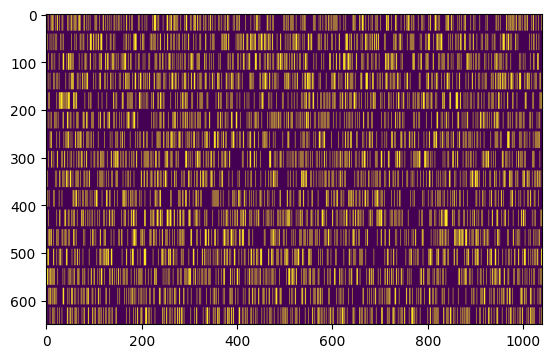

In [3]:
plt.imshow(wfm.mask); plt.show()

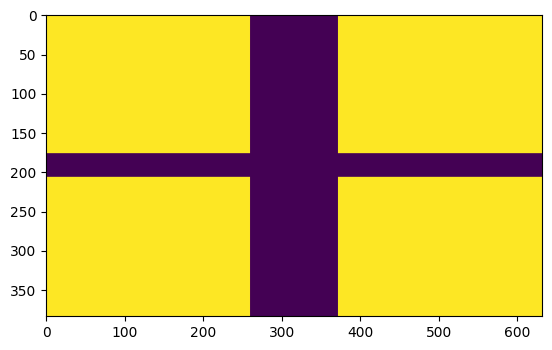

In [4]:
plt.imshow(wfm.bulk); plt.show()

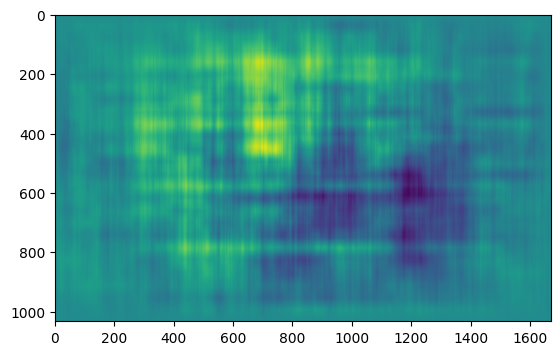

In [5]:
plt.imshow(wfm.balancing); plt.show()

### Mask upscaling

The `codedmask` function accepts optional parameters to increase the sampling resolution of the mask pattern. By default both upscaling parameters are set to 1, and no upscaling is applied.

In [6]:
wfm_upscaled = codedmask("wfm_mask.fits", upscale_x=5, upscale_y=8)  # a (5, 8) upscaling results in square mask elements

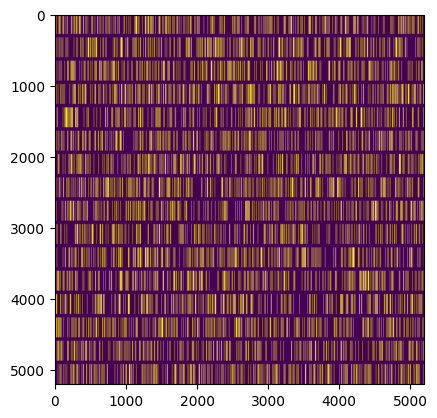

In [7]:
plt.imshow(wfm_upscaled.mask); plt.show()

### Mask parameters

The `.specs` property returns essential camera parameters:

In [8]:
pprint(wfm.specs)

CodedMaskSpecs(detector_minx=-78.988,
               detector_maxx=78.988,
               detector_miny=-76.5255,
               detector_maxy=76.5255,
               mask_deltax=0.25,
               mask_deltay=0.4,
               mask_thickness=0.15,
               mask_minx=-130,
               mask_miny=-130,
               mask_maxx=130,
               mask_maxy=130,
               slit_deltax=0.25,
               slit_deltay=14.0,
               mask_detector_distance=203.05)


## Loading simulation data

The `SimulationDataLoader` manages WFM instrument simulation data, providing access to:

- Event data
- Instrument pointings
- Camera rotations parameters
- Instrument pointings parameters

The `simulation` function initializes a `SimulationDataLoader` instance from a FITS file path. Simulation data is stored internally as Astropy's FITSrec objects, and are accessible through the loader's `.data` property.

For additional details on the simulation framework and data structure, refer to the Francesco Ceraudo's WISEMAN documentation.

In [9]:
from bloodmoon import simulation

sdl = simulation("simdir/cam1a/cam1a_reconstructed.fits")
pprint(sdl.pointings)
pprint(sdl.rotations)

{'x': CoordEquatorial(ra=266.4, dec=61.06),
 'z': CoordEquatorial(ra=266.4, dec=-28.94)}
{'x': CoordHorizontal(az=0.0, al=0.0), 'z': CoordHorizontal(az=0.0, al=90.0)}


A useful auxiliary routine is `simulation_files`. It parses datafiles paths from a simulation directory and loads them into a dictionary.

In [10]:
from bloodmoon import simulation_files

filepaths = simulation_files("simdir/")
pprint(filepaths)

{'cam1a': {'detected': PosixPath('simdir/cam1a/cam1a_detected_plane.fits'),
           'reconstructed': PosixPath('simdir/cam1a/cam1a_reconstructed.fits'),
           'sources': PosixPath('simdir/cam1a/cam1a_sources.fits')},
 'cam1b': {'detected': PosixPath('simdir/cam1b/cam1b_detected_plane.fits'),
           'reconstructed': PosixPath('simdir/cam1b/cam1b_reconstructed.fits'),
           'sources': PosixPath('simdir/cam1b/cam1b_sources.fits')}}


## Detector images

With the camera and simulation data loader instances in hand, we can create detector images from the photon event data:

In [11]:
from bloodmoon import codedmask, simulation
from bloodmoon import count

wfm = codedmask("wfm_mask.fits")
sdl = simulation("simdir/cam1a/cam1a_reconstructed.fits")

detector_counts, bins = count(wfm, sdl.data)

The `count` function generates a 2D histogram of photon events, similar to NumPy's histogram2d. It automatically:

* Determines appropriate binning based on the camera geometry and upscaling factors
* Takes into account the detector's bulk (sensitivity) pattern
* Returns both the counts array and the binning structure

This creates a detector image for further analysis and reconstruction.

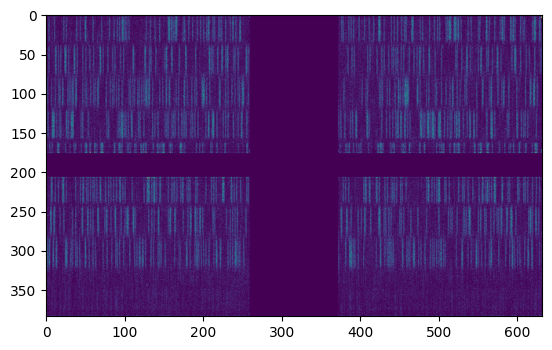

In [12]:
plt.imshow(detector_counts); plt.show()

## Reconstruction by cross-correlation

The `decode` function implements balanced reconstruction by cross-correlation:

In [13]:
from bloodmoon import codedmask, simulation, count
from bloodmoon import decode

wfm = codedmask("wfm_mask.fits")
sdl = simulation("simdir/cam1a/cam1a_reconstructed.fits")

detector, _ = count(wfm, sdl.data)

balanced = decode(wfm, detector)

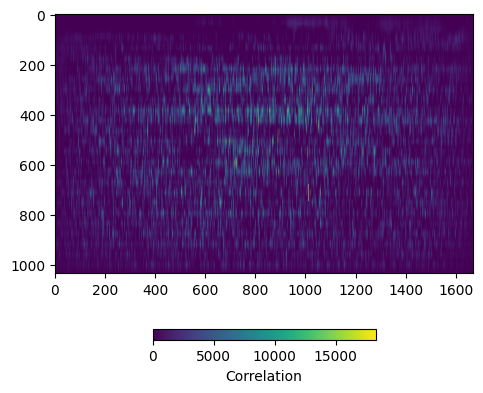

In [14]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(balanced, vmin=0, vmax=-balanced.min())
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", shrink=.45)
plt.show()

## Variance and SNR

The `variance` function computes statistical variance for camera and detector images:


In [15]:
from bloodmoon import codedmask, simulation, count, decode
from bloodmoon import variance

wfm = codedmask("wfm_mask.fits")
sdl = simulation("simdir/cam1a/cam1a_reconstructed.fits")

detector, _ = count(wfm, sdl.data)
balanced = decode(wfm, detector)

var_ = variance(wfm, detector)

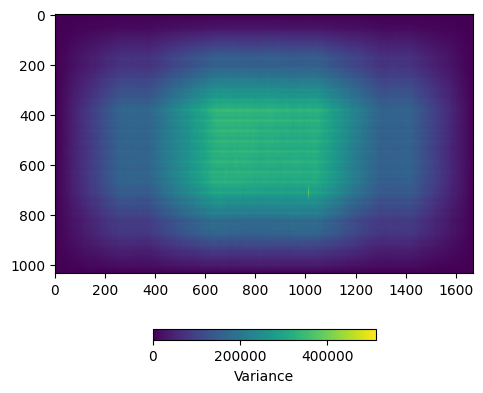

In [16]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(var_, vmin=0, vmax=var_.max())
fig.colorbar(c0, ax=ax, label="Variance", location="bottom", shrink=.45)
plt.show()

The `snratio` function calculates signal-to-noise ratio significance, handling edge cases such as sparse count distributions from off-axis sources.

In [17]:
from bloodmoon import codedmask, simulation, count, decode, variance
from bloodmoon import snratio

wfm = codedmask("wfm_mask.fits")
sdl = simulation("simdir/cam1a/cam1a_reconstructed.fits")

detector, _ = count(wfm, sdl.data)
balanced = decode(wfm, detector)

snr = snratio(balanced, variance(wfm, detector))

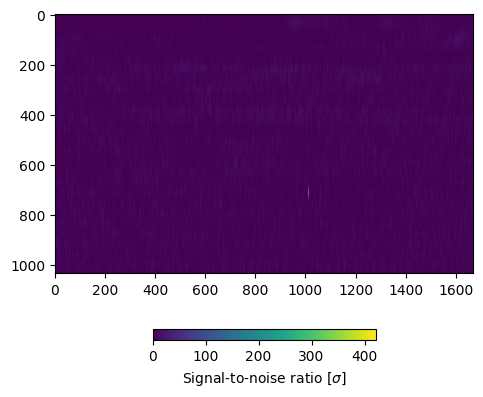

In [18]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(snr, vmin=0, vmax=snr.max())
fig.colorbar(c0, ax=ax, label="Signal-to-noise ratio [$\sigma$]", location="bottom", shrink=.45)
plt.show()

## Composing images from different cameras

The WFM's dual-camera system enables improved source localization through combined observations. The `compose` function performs the following operations:

* Combines reconstructed sky images from two cameras
* Generates a single composite image
* Returns both the composite image and a mapping function relating positions between composite and original images

In [4]:
from bloodmoon import codedmask, simulation, simulation_files, count, decode
from bloodmoon.images import compose

filepaths = simulation_files("simdir/")
wfm = codedmask("wfm_mask.fits", upscale_x=5, upscale_y=8)

sdl_1a = simulation(filepaths["cam1a"]["reconstructed"])
detector_1a, _ = count(wfm, sdl_1a.data)
balanced_1a = decode(wfm, detector_1a)

# repeat for the second camera
sdl_1b = simulation(filepaths["cam1b"]["reconstructed"])
detector_1b, _ = count(wfm, sdl_1b.data)
balanced_1b = decode(wfm, detector_1b)

composed, composed_f = compose(balanced_1a, balanced_1b)

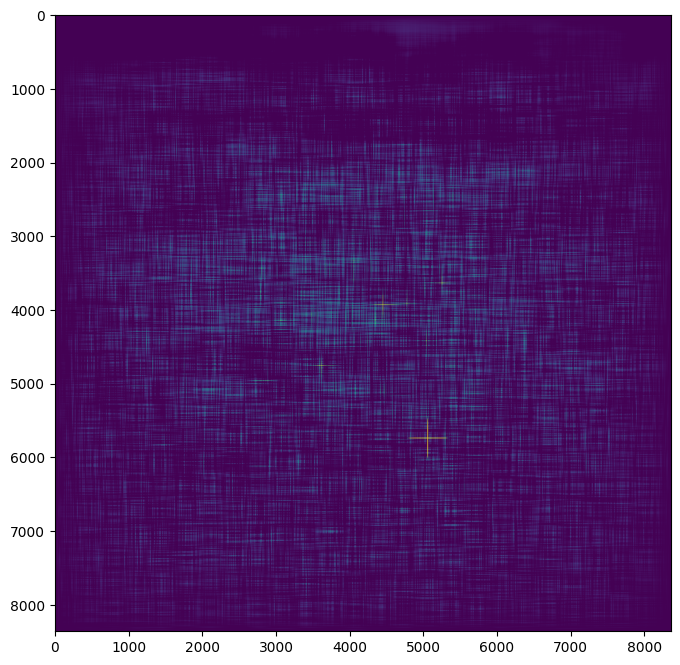

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=-composed.min())
plt.show()

Here we map the brightest point in the composite back to its location in each camera's image:

In [7]:
from bloodmoon.images import argmax

argmax_composed = argmax(composed)
argmax_1a, argmax_1b = composed_f(*argmax_composed)

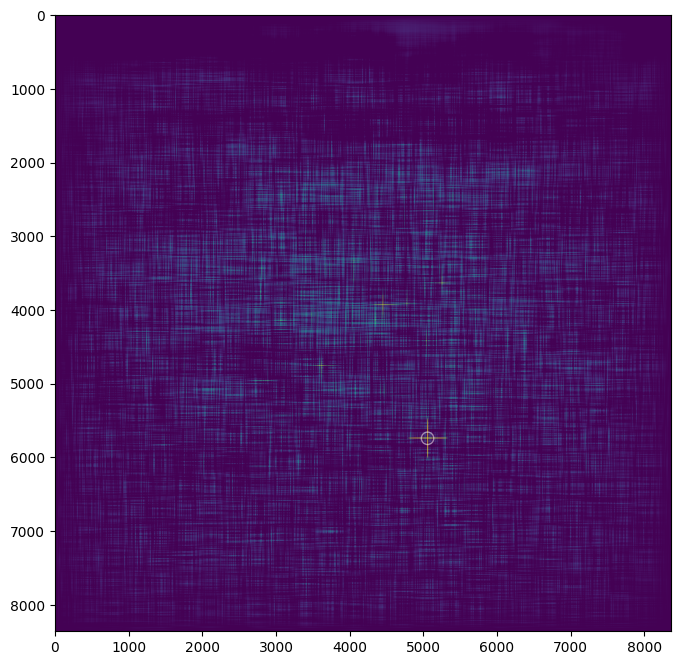

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=-composed.min())
ax.scatter(*argmax_composed[::-1], s=80, facecolors='none', edgecolors='white', alpha=0.5)
plt.show()

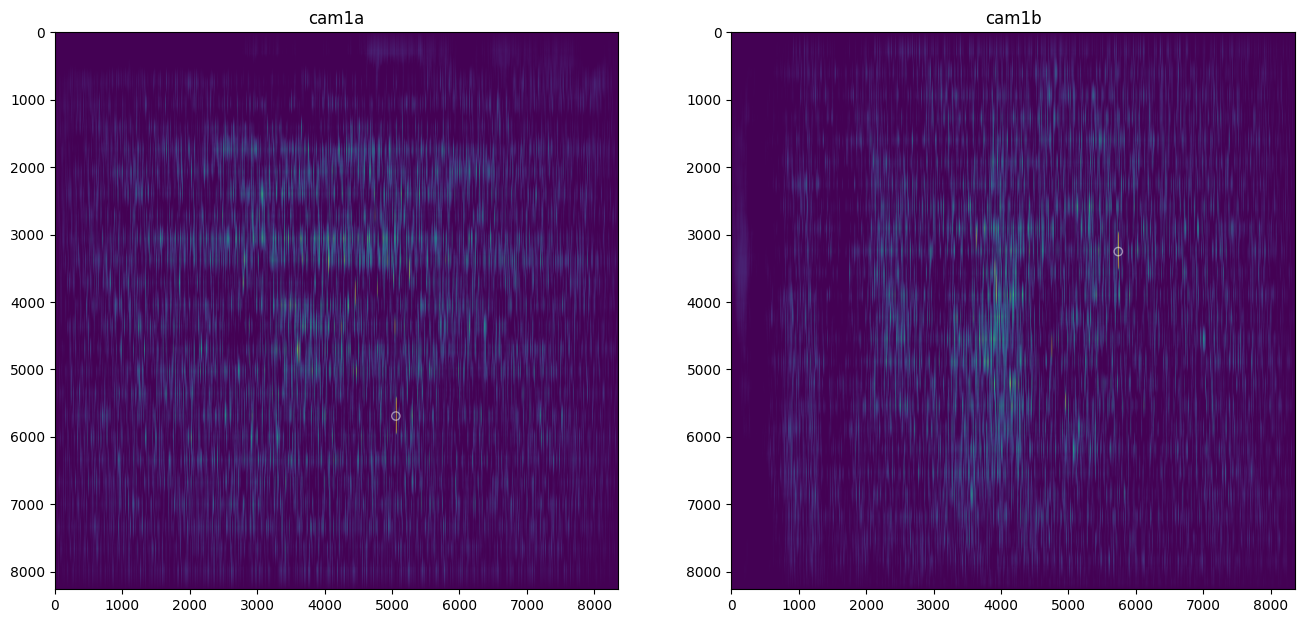

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
for ax, b, bmax, title in zip(
        axs,
        [balanced_1a, balanced_1b],
        [argmax_1a, argmax_1b],
        ["cam1a", "cam1b"],
):
    c0 = ax.imshow(b, vmin=0, vmax=-b.min())
    ax.scatter(bmax[1], bmax[0], facecolors='none', edgecolors='white', alpha=0.5)
    ax.set_title(title)
plt.show()

When working with composed images, detector pixels should be square to avoid distortions. This typically requires upscaling the camera objects, but there's an important trade-off to consider because higher resolutions result in higher memory and CPU usage. A practical alternative workflow is to:

1. Perform initial analysis and reconstruction at lower resolution.
2. Upscale only the final images for visualizing results.

In [12]:
import numpy as np
from bloodmoon.images import _upscale

arr = np.array([
    [1, 2],
    [3, 4],
])
# no magic here, we just repeat elements along each dimension.
# note that, for compatibility, we use `x` and `y` and not `rows` and `cols`
_upscale(arr, upscale_x=2, upscale_y=3)

array([[1, 1, 2, 2],
       [1, 1, 2, 2],
       [1, 1, 2, 2],
       [3, 3, 4, 4],
       [3, 3, 4, 4],
       [3, 3, 4, 4]])

## Simulating shadowgrams and sources

The package provides functions for generating synthetic shadowgrams with configurable physical effects:

In [18]:
from bloodmoon import codedmask, model_shadowgram

wfm = codedmask("wfm_mask.fits")
sg = model_shadowgram(wfm, shift_x=0., shift_y=0.)

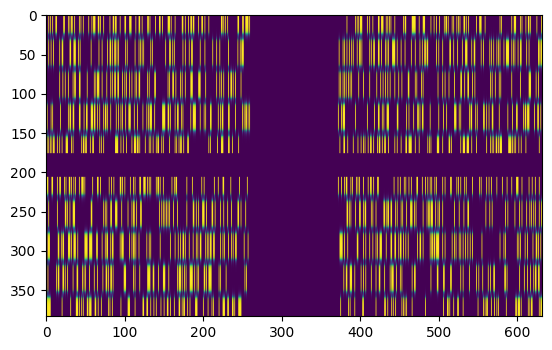

In [19]:
plt.imshow(sg); plt.show()

The `model_shadowgram` function implements:

* Vignetting correction
* Detector position reconstruction effects
* Sub-pixel sampling resolution

Each effect can be individually configured through function parameters.

In [21]:
sg = model_shadowgram(wfm, shift_x=0., shift_y=0., vignetting=False, psfy=False)

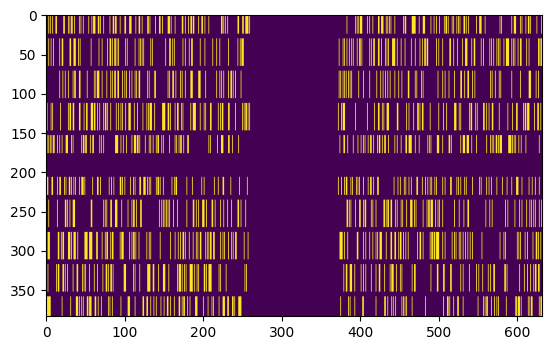

In [22]:
plt.imshow(sg); plt.show()

## Shifts and coordinates transformation

Source positions in shadowgram generation use 'shifts' - spatial displacements between shadow pattern center and detector center. This coordinate system provides position representation independent of mask-detector distance.

In [24]:
from bloodmoon import codedmask
from bloodmoon import model_shadowgram

wfm = codedmask("wfm_mask.fits")
sg = model_shadowgram(wfm, shift_x=150.02, shift_y=100.23)

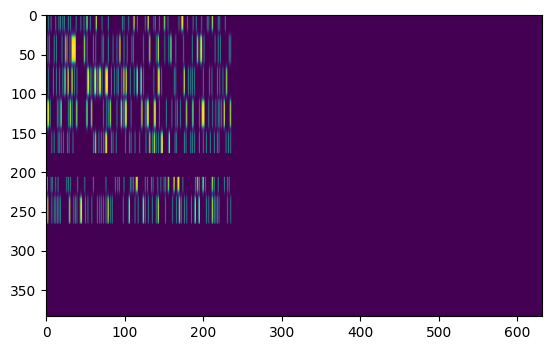

In [25]:
plt.imshow(sg); plt.show()  # remember imshow plots with graphics convention, i.e. y grows top to bottom.

Shifts maps to astronomical coordinates, once one takes into account the camera design (e.g., the distance between the mask and the detector), and the instrument's rotations and pointings.

In [26]:
from bloodmoon import codedmask, simulation
from bloodmoon.coords import shift2equatorial

wfm = codedmask("wfm_mask.fits")
sdl = simulation("simdir/cam1a/cam1a_reconstructed.fits")

shift_x, shift_y =150.02, 100.23
ra, dec = shift2equatorial(sdl, wfm, shift_x, shift_y)

print(f"(x={shift_x}, y={shift_y}) -> (ra={ra:+.2f}, dec={dec:+.2f})")

(x=150.02, y=100.23) -> (ra=+244.58, dec=+6.98)


The function `shift2equatorial` deals with individual shift-coordinates. To convert a grid of shift coordinates we use `shiftgrid2equatorial`. 

In [27]:
from bloodmoon import codedmask, simulation
from bloodmoon.coords import shiftgrid2equatorial

wfm = codedmask("wfm_mask.fits")
sdl = simulation("simdir/cam1a/cam1a_reconstructed.fits")

ras, decs = shiftgrid2equatorial(sdl, wfm, *wfm.bins_sky)

In [28]:
i, j = 400, 1300
shift_x, shift_y = wfm.bins_sky.x[j], wfm.bins_sky.y[i]
ra, dec = shift2equatorial(sdl, wfm, shift_x, shift_y)
ra_, dec_ = ras[i][j], decs[i][j]
print(f"with `shift2equatorial`: \t(ra= {ra:+.2f}, dec= {dec:+.2f})\nwith `shiftgrid2equatorial`: \t(ra= {ra_:+.2f}, dec= {dec_:+.2f})")

with `shift2equatorial`: 	(ra= +277.67, dec= +0.81)
with `shiftgrid2equatorial`: 	(ra= +277.67, dec= +0.81)


## Simulating sky images

There are two methods for generating simulated simulated sky images:

1. creating a shadowgram and decoding it manually.
2. using the `model_sky` function:

In [30]:
from bloodmoon import codedmask, model_sky

wfm = codedmask("wfm_mask.fits")
sky = model_sky(wfm, shift_x=150.02, shift_y=100.23, fluence=1000)

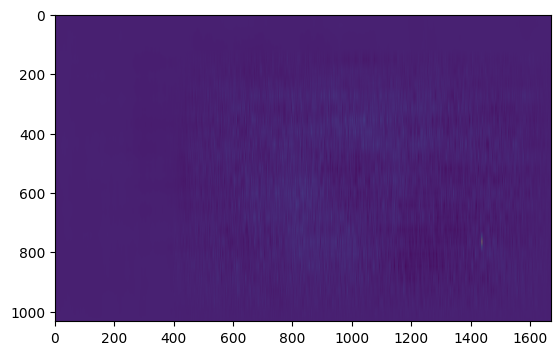

In [31]:
plt.imshow(sky); plt.show() 

The `model_sky` function internally handles both shadowgram generation and decoding. Like `model_shadowgram`, it includes realistic instrumental effects by default and offers the same parameters for controlling which effects are included.

## Fitting sources

To determine source parameters, bloodmoon provides the `optimize` routine.

In [32]:
from bloodmoon import codedmask, model_sky, optimize
from bloodmoon.images import argmax

wfm = codedmask("wfm_mask.fits")
simulated_sky = model_sky(wfm, shift_x=150.02, shift_y=100.23, fluence=1000)

# note optimize takes matrix indices for arguments, but returns shifts.
shift_x, shift_y, fluence = optimize(wfm, simulated_sky, argmax(simulated_sky))
print(f"source direction: x= {shift_x:+.2f}, y= {shift_y:+.2f}, fluence= {fluence:2f}")

source direction: x= +150.02, y= +100.23, fluence= 963.881021


Note that while the initial position is provided as array indices, the optimized results are returned in shift coordinates.

## Subtracting sources

Let's demonstrate a key analysis technique: removing a bright source from a complex field to reveal fainter objects. We'll use a simulation of the Galactic Center region where Scorpius X-1, one of the brightest X-ray sources in the sky, dominates the field:

In [1]:
from bloodmoon import codedmask, simulation, simulation_files, decode, count, model_sky, optimize
from bloodmoon.images import argmax, compose, _upscale

filepaths = simulation_files("simdir/")

# loads camera specs and simulation dataset
wfm = codedmask("wfm_mask.fits", upscale_x=5)
sdl_1a = simulation(filepaths["cam1a"]["reconstructed"])

# computes detector images
detector_1a, _ = count(wfm, sdl_1a.data)
# decode detector images using cross correlation
balanced_1a = decode(wfm, detector_1a)
# fits most brilliant source position
source_1a = optimize(wfm, balanced_1a, argmax(balanced_1a))
# simulate source and subtract
residual_1a = balanced_1a - model_sky(wfm, *source_1a)

In [2]:
# repeat for the second camera.
sdl_1b = simulation(filepaths["cam1b"]["reconstructed"])
detector_1b, _ = count(wfm, sdl_1b.data)
balanced_1b = decode(wfm, detector_1b)
source_1b = optimize(wfm, balanced_1b, argmax(balanced_1b))
residual_1b = balanced_1b - model_sky(wfm, *source_1b)

In [5]:
# compose upscaled images for plotting
composed, _ = compose(
    _upscale(balanced_1a, upscale_x=1, upscale_y=8),
    _upscale(balanced_1b, upscale_x=1, upscale_y=8),
    strict=False,
)
composed_residuals, _ = compose(
    _upscale(residual_1a, upscale_x=1, upscale_y=8),
    _upscale(residual_1b, upscale_x=1, upscale_y=8),
    strict=False,
)

Before subtraction, the sky image we obtain by cross-correlation is:

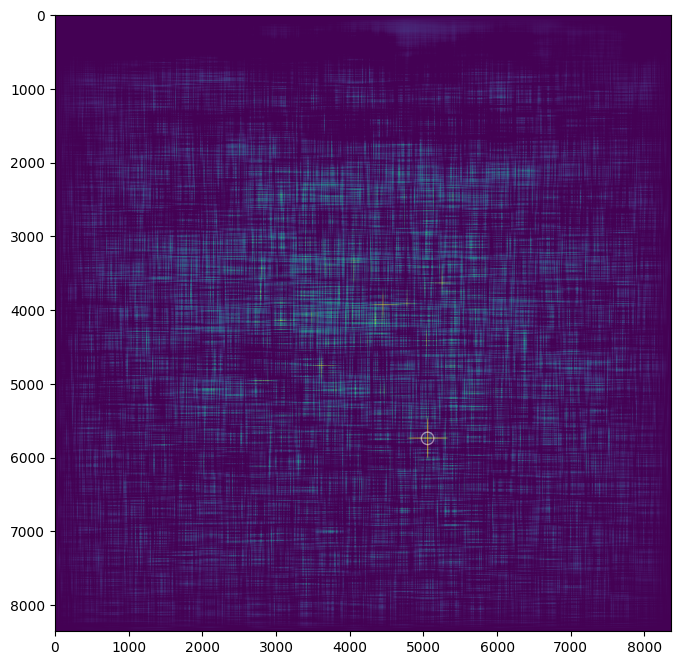

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=np.quantile(composed, 1 - 2 * 10 ** -4))
ax.scatter(*argmax(composed)[::-1], s=80, facecolors='none', edgecolors='white', alpha=0.5)
plt.show()

After subtraction:

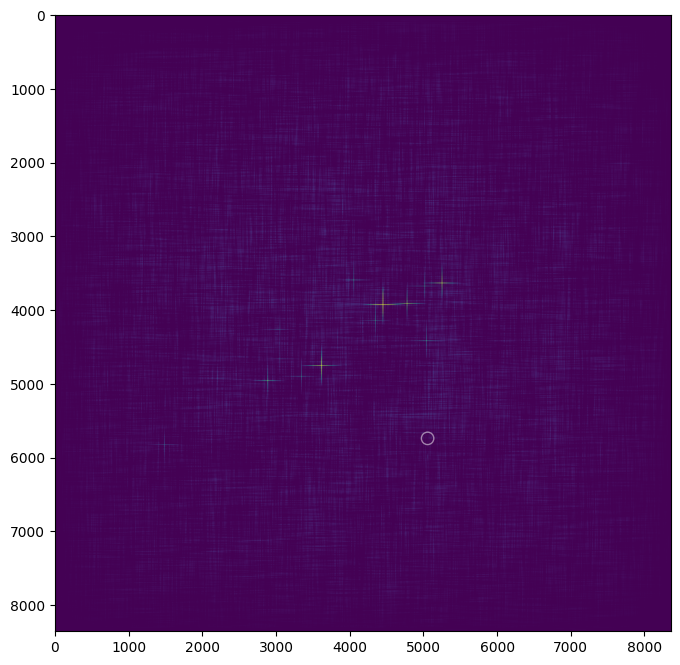

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed_residuals, vmin=0, vmax=np.quantile(composed, 1 - 2 * 10 ** -4))
ax.scatter(*argmax(composed)[::-1], s=80, facecolors='none', edgecolors='white', alpha=0.5)
plt.show()

This technique is fundamental to the IROS (Iterative Removal of Sources) algorithm, which progressively reveals fainter sources by removing brighter ones from the field.

# IROS

The `iros` function of bloodmoon automatize the source subtraction process. Suppose we want to see the last residual sky image after the removal of seven sky sources. With bloodmoon we can implement this operation in a very concise way:

In [1]:
from bloodmoon import simulation_files, codedmask, simulation, iros

filepaths = simulation_files("simdir/")

wfm = codedmask("wfm_mask.fits", upscale_x=5)
sdl1a = simulation(filepaths["cam1a"]["reconstructed"])
sdl1b = simulation(filepaths["cam1b"]["reconstructed"])

loop = iros(wfm, sdl1a, sdl1b, max_iterations=7)

for i, (sources, residuals) in enumerate(loop, start=1):
    print(f"at iteration {i}..")
    sources_1a, sources_1b = sources
    residuals_1a, residuals_1b = residuals
    # .. you do your things here ..

at iteration 1..
at iteration 2..
at iteration 3..
at iteration 4..
at iteration 5..
at iteration 6..
at iteration 7..


In [2]:
from bloodmoon.images import compose, _upscale

composed, _ = compose(
    _upscale(residuals_1a, upscale_x=1, upscale_y=8),
    _upscale(residuals_1b, upscale_x=1, upscale_y=8),
    strict=False,
)

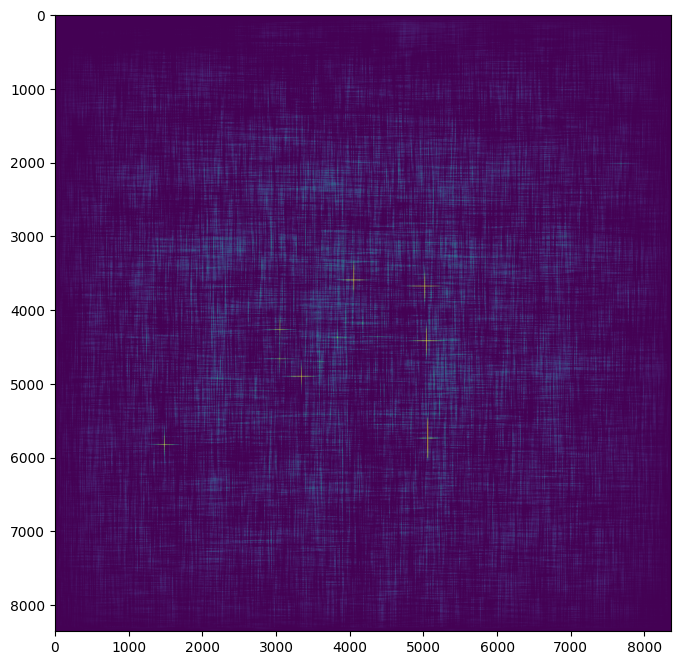

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(composed, vmin=0, vmax=np.quantile(composed, 1 - 2 * 10 ** -4))
plt.show()

We've already subtracted 7 sources and many more remain resolvable in the residual!

## Accessing Documentation

The library includes documentation for its functions and classes. You can access this documentation in Jupyter notebooks in two ways:

```python
# Using IPython's ? syntax
?fun  # Shows brief documentation
??fun # Shows full source code and documentation

# Using Python's built-in help
help(fun)
```

For example:

In [8]:
from bloodmoon import iros

?iros

Signature:
iros(
    camera: bloodmoon.mask.CodedMaskCamera,
    sdl_cam1a: bloodmoon.io.SimulationDataLoader,
    sdl_cam1b: bloodmoon.io.SimulationDataLoader,
    max_iterations: int,
    snr_threshold: float = 0.0,
    vignetting: bool = True,
    psfy: bool = True,
) -> Iterable
Docstring:
Performs Iterative Removal of Sources (IROS) for dual-camera WFM observations.

This function implements an iterative source detection and removal algorithm for
the WFM coded mask instrument. For each iteration, it:
1. Ranks source candidates by SNR and integrated intensity
2. Matches compatible source positions between orthogonal cameras
3. Fits source parameters
4. Removes fitted sources from the sky image
5. Repeats until no significant sources remain or max iterations reached

Args:
    camera: CodedMaskCamera instance containing mask/detector geometry and parameters
    sdl_cam1a: SimulationDataLoader for the first WFM  camera
    sdl_cam1b: SimulationDataLoader for the second WFM camera
   